In [1]:
from urllib.request import urlopen
import json
import re
from urllib.parse import quote
import pandas as pd
from pandas.io.json import json_normalize
import collections
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
# conda install -c phlya adjusttext 
#from adjustText import adjust_text

In [2]:
###### Get data #####
n = 2500

# Initial query - get most active wikis
query = "http://www.wikia.com/api/v1/Wikis/List?expand=1&limit="+str(n)+"&batch=1"
response = urlopen(query)
wikisource = response.read()
data = json.loads(wikisource)
df = pd.DataFrame(data['items'])
fullDataSet = df
 
# Search for more wikis (primarily based on the different hub names)
def searchForWiki(search, n):
    querySearch = "http://www.wikia.com/api/v1/Wikis/ByString?expand=1&string="+str(search)+"&limit="+str(n)+"&batch=1&includeDomain=true"
    response = urlopen(querySearch)
    data = json.loads(response.read())
    return pd.DataFrame(data['items']) 
    
# use hubs in dataset to searsh for new wikis
for hub in set(df["hub"]):
    df2 = searchForWiki(hub, n)
    fullDataSet = fullDataSet.append(df2)
    print("%s wikis found in %s" % (str(len(df2)), hub))
    

250 wikis found in Comics
250 wikis found in Other
250 wikis found in Books
250 wikis found in Games
30 wikis found in Lifestyle
250 wikis found in Movies
250 wikis found in Music
250 wikis found in TV


In [10]:
# remove inactive wikis and duplicates
def findActiveWikis(dataSet):
    activeDataSet = pd.DataFrame()
    # find stats in dataset
    for s in dataSet['stats']:
        data = dataSet.loc[dataSet['stats']==s]
        # only add when at least 1 active
        if s['activeUsers']>1:
            activeDataSet = activeDataSet.append(data)
    # remove duplicates
    activeDataSet = activeDataSet.drop_duplicates(subset="id")
    activeDataSet = activeDataSet.reset_index(drop=True)
    return activeDataSet


activeDataSet = findActiveWikis(fullDataSet)
print("full data set has %s data, while only %s is actively used." % (len(fullDataSet),len(activeDataSet)))

2030
259


In [4]:
# search online to find the username based on the userID
def findUsernames(userID):
    querySearch = "http://community.wikia.com/wiki/Special:Search?search="+userID+"&fulltext=Search&ns2=1"
    response = urlopen(querySearch)
    wikisource = response.read()
    usernames = set(re.findall("User:(\w+)?",str(wikisource)))
    return usernames

In [5]:
# search online to find the wikis which the user use, 
# though his resent activity found though username
def findWikisThroughUser(usernames):
    wikis = []
    for username in usernames:
        querySearch = "http://community.wikia.com/index.php?limit=1000&tagfilter=&title=Special%3AContributions&target="+username+"&namespace=&tagfilter=&year=&month=-1"
        response = urlopen(querySearch)
        wikisource = response.read()
        wikis.append(set(re.findall("Adoption:(\w+)?",str(wikisource))))
    return wikis

In [6]:
# When a connection to a wiki is found, the user is added to 'topUsers' in the dataframe
def addUserToWiki(wiki,userID, dataSet):
    series = dataSet.loc[dataSet['name'] == wiki]
    topUsers = list(series['topUsers'].values)
    topUsers = list(itertools.chain.from_iterable(topUsers))
    if userID not in topUsers:
        topUsers.append(int(userID))
        dataSet.at[series.index.values[0], "topUsers"] = set(topUsers)
    return dataSet

In [7]:
# print/caculate the number of wiki's which the user is connected to
def printUserInWiki(userID, dataSet):
    i = 0
    j = 0
    for users in list(dataSet['topUsers'].values):
        if int(userID) in list(users):
            i+=1
        else:
            j+=1
    #print("%s user found in %s wikis, not in %s wikis" % (userID,i,j))  
    return i

In [8]:
# adding the users (and wikis, if new are discovered) to the dataframe
def addWikis(userID, dataSet):
    wikiList = findWikisThroughUser(findUsernames(userID))
    i = printUserInWiki(userID, dataSet)
    
    # the data is listed nested
    for wikis in list(wikiList):
        for wiki in set(list(wikis)):
            wiki = wiki.replace("_", " ")
            # If wiki already exsists in the dataset, the user is assed
            if wiki in list(dataSet['name']):
                #print("%s found in Dataset" % wiki)
                dataSet = addUserToWiki(wiki,userID, dataSet)
            # if the wiki does not exsist, a search for it is made.
            else:
                wiki = wiki.replace(" ", "_")
                wikidf = searchForWiki(wiki, 250)
                # wikidf = findActiveWikis(wikidf)
                dataSet = dataSet.append(wikidf)
                dataSet = dataSet.reset_index(drop=True)
                wiki = wiki.replace("_", " ")
                if wiki in dataSet['name']:
                    dataSet = addUserToWiki(wiki,userID, dataSet)
                    print("wiki %s added to Dataset and user added" % wiki)
                #else:
                    #print("--- %s not found in Dataset" % wiki)
    
    #j = printUserInWiki(userID, fullDataSet)
    #print("User added to %s new wikis" % j-i)
    return dataSet

In [11]:
# make graph
G = nx.Graph()

# find topusers
#topUsers = []
topUsers = [x for x in activeDataSet["topUsers"]]
topUsers = list(itertools.chain.from_iterable(topUsers))
for i in range(len(topUsers)):
    activeDataSet = addWikis(str(topUsers[i]), activeDataSet)
    activeDataSet = findActiveWikis(activeDataSet)
    if(i%25==0):
        print("%s af %s, wiki count = %s" % (str(i),str(len(topUsers)),str(len(activeDataSet))))
        
topUsers = [x for x in activeDataSet["topUsers"]]
topUsers = list(itertools.chain.from_iterable(topUsers))

counter=collections.Counter(topUsers)
#print(counter)
#print(counter.values())
#print(counter.keys())
print(counter.most_common(7))

# add nodes
for wiki in activeDataSet["name"]:
    G.add_node(wiki, hub=set(activeDataSet['hub'].loc[activeDataSet['name'] ==wiki].values))


0 af 2039, wiki count = 259
25 af 2039, wiki count = 259
50 af 2039, wiki count = 894
75 af 2039, wiki count = 894
100 af 2039, wiki count = 894
125 af 2039, wiki count = 894
150 af 2039, wiki count = 894
175 af 2039, wiki count = 894
200 af 2039, wiki count = 894
225 af 2039, wiki count = 894
250 af 2039, wiki count = 894
275 af 2039, wiki count = 894
300 af 2039, wiki count = 894
325 af 2039, wiki count = 894
350 af 2039, wiki count = 894
375 af 2039, wiki count = 894
400 af 2039, wiki count = 894
425 af 2039, wiki count = 894
450 af 2039, wiki count = 894
475 af 2039, wiki count = 894
500 af 2039, wiki count = 894
525 af 2039, wiki count = 894
550 af 2039, wiki count = 894
575 af 2039, wiki count = 894
600 af 2039, wiki count = 894
625 af 2039, wiki count = 894
650 af 2039, wiki count = 894
675 af 2039, wiki count = 894
700 af 2039, wiki count = 894
725 af 2039, wiki count = 894
750 af 2039, wiki count = 894
775 af 2039, wiki count = 894
800 af 2039, wiki count = 894
825 af 2039, wi

In [12]:
print(len(topUsers))

6239


In [22]:
# find the wiki names of the users
users = {}
for user in counter.most_common():
    user = user[0]
    for k, v in activeDataSet.T.items():
        if user in v["topUsers"]:
            if user not in users:
                users[user] = []
            users[user].append(v['name'])

# create edges between all wikis which share users
def createEdges(G,userWikis):
    length = len(userWikis)
    if length==1:
        return G
    elif length>1:
        wiki = userWikis.pop()
        for w in userWikis:
            if G.has_edge(wiki, w):
                G[wiki][w]['weight']+=1
            else:
                G.add_edge(wiki,w,weight=1)
        return createEdges(G,userWikis)
    else:
        return G


In [23]:
# iterate over all users
for k,v in users.items():
    #print(set(v))
    G = createEdges(G,set(v))

In [46]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.5,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01, #0.01
                          strongGravityMode=False, #False
                          gravity=30, #15

                          # Log
                          verbose=True)


# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:24<00:00, 89.81it/s]

BarnesHut Approximation  took  6.57  seconds
Repulsion forces  took  14.75  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.60  seconds
AdjustSpeedAndApplyForces step  took  0.81  seconds


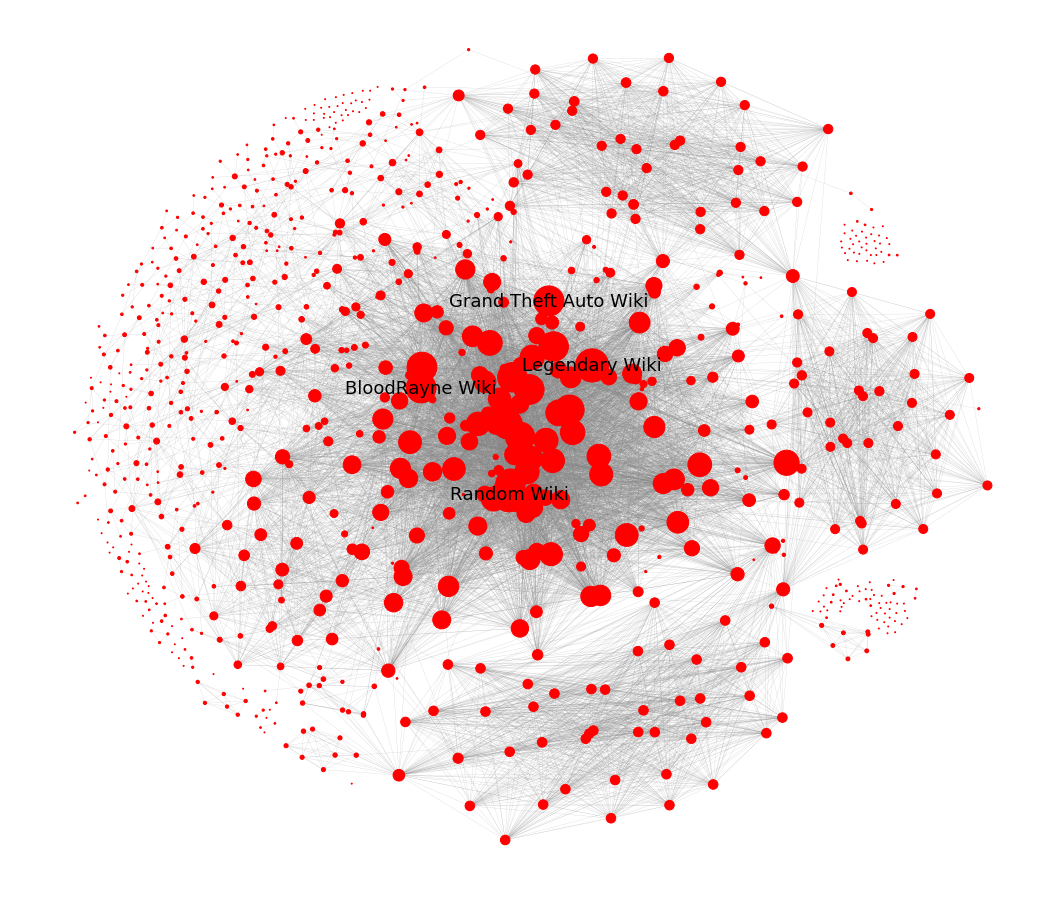

In [58]:
# plot figure
plt.figure(figsize=(18, 16))             
node_size = [(G.degree(node, weight='weight')*2)+1 for node in G.nodes()]  

labels = {}    
for node in G.nodes():
    if G.degree(node, weight='weight')*2 > 890:
        #set the node name as the key and the label as its value 
        labels[node] = node

node_label = [node for node in G.nodes() ]
nx.draw_networkx_nodes(G, positions, nodelist=G.nodes, node_size=node_size,cmap=plt.get_cmap('jet'))
nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
nx.draw_networkx_labels(G, positions, labels=labels, font_size=18, font_color='k', font_weight='normal', alpha=2.0)
#texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
#adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.axis('off')
plt.savefig('wiki.png')
plt.show()

In [32]:
len(G.edges())

11003

In [27]:
len(G.nodes())

905